# Adversarial Examples on SHREC14 using PointNet


In [1]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import sys
import os
import random


# third party libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as funcs
import torch_sparse as tsparse

REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')),".."))
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SRC_DIR = os.path.join(REPO_ROOT,"src")
SHREC14 =  os.path.join(REPO_ROOT,"datasets/shrec14")

#PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/real.pt")
ENCODER_PARAMS = os.path.join(REPO_ROOT, "model_data/SHREC14_enc3.pt")
DECODER_PARAMS = os.path.join(REPO_ROOT, "model_data/SHREC14_dec3.pt")
CLASSIFIER_PARAMS = os.path.join(REPO_ROOT,'model_data/SHREC14_cla3.pt')

# repository modules
sys.path.insert(0, SRC_DIR)
import models
import train
import dataset
import utils


## Training

### Shape Classification using SHREC14

In [2]:
traindata = dataset.Shrec14Dataset(SHREC14,device=DEVICE, train=True, test=False)
testdata = dataset.Shrec14Dataset(SHREC14, device=DEVICE, train=False, test=True)

In [3]:
from torch import nn
from models.pointnet import SimplePointNet 

#autoencoder
LATENT_SPACE = 128
NUM_POINTS = 7000

# encoder
ENC = SimplePointNet(
    latent_dimensionality=LATENT_SPACE*2,
    convolutional_output_dim=512,
    conv_layer_sizes=[32, 128, 256],
    fc_layer_sizes=[512, 256, 128],
    transformer_positions=[0]).to(DEVICE)

# decoder
class Decoder(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.fc1 = nn.Sequential(nn.Linear(LATENT_SPACE, 1024), 
                        nn.LeakyReLU(), nn.Linear(1024, 2048),
                        nn.LeakyReLU(), nn.Linear(2048, NUM_POINTS*3))
    
    def forward(self, x):
        x = self.fc1(x).view(x.shape[0],NUM_POINTS,-1)
        xfc = x
        return x
DEC = Decoder().to(DEVICE)

    
# classifier
CLA = nn.Sequential(
    nn.Linear(LATENT_SPACE, 64), nn.ReLU(), nn.Linear(64,10)).to(DEVICE)

'''
# auto-encoder
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist
chamLoss = chamfer_3DDist()

DEC = Decoder().cuda()
model =  testdata[0].to(DEVICE)

def loss_fun(data):
    data.pos = data.pos.view(data.y.shape[0],-1,3)
    data.oripos = data.oripos.view(data.y.shape[0],-1,3)

    latent = ENC(data.to(DEVICE),None,None)

    #variational
    z_mu = latent[...,:LATENT_SPACE]
    z_var  = latent[...,LATENT_SPACE:]
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    latent = eps.mul(std).add_(z_mu)       

    rec = model.oripos[None,...]+DEC(latent)
    dist1, dist2, idx1, idx2 =  chamLoss(data.oripos, rec)
    loss = 1e2*torch.mean(dist1+dist2)
    
    kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
    loss += 1e-5*kl_loss
        
    pdist = lambda A, B: A.pow(2).sum(2, keepdim = True) - 2 * torch.bmm(A, B.transpose(1,2)) + B.pow(2).sum(2, keepdim = True).transpose(1,2)
    sploss = F.relu(2e-3-pdist(rec,rec),2e-3).mean()

    loss = loss + 1e2*sploss 
    return loss
'''

ENC.load_state_dict(torch.load(ENCODER_PARAMS, map_location=DEVICE))
DEC.load_state_dict(torch.load(DECODER_PARAMS, map_location=DEVICE))
CLA.load_state_dict(torch.load(CLASSIFIER_PARAMS, map_location=DEVICE))
ENC.eval()
DEC.eval()
CLA.eval()

Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.70it/s]

tensor(1.)


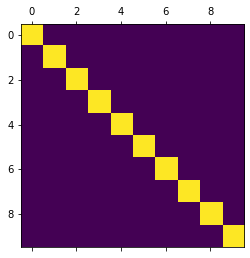

In [4]:
class SHREC14Classifier(nn.Module):
    def __init__(self, enc, cla):
        super().__init__()
        self.cla=cla
        self.enc=enc
        
    def forward(self,pos):    
        lsp = self.enc(pos)[...,:LATENT_SPACE]
        return self.cla(lsp)
    
MODEL = SHREC14Classifier(ENC,CLA).to(DEVICE)
accuracy, confusion = train.evaluate(
    eval_data=testdata, classifier=MODEL, epoch_number=1)

# show accuracy
print(accuracy)
plt.matshow(confusion)
plt.show()

## Visualization procedures

In [12]:
import plotly
import plotly.graph_objects as go

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()
    
def compare(pos1, faces1, pos2, faces2):
    n,m = pos1.shape[0], pos2.shape[0]
    tmpx = torch.cat([pos1, pos2],dim=0)
    tmpf = torch.cat([faces1, faces2+n], dim=0)
    color = torch.zeros([n+m],dtype=pos1.dtype, device=pos1.device)
    color[n:] = (pos1-pos2).norm(p=2,dim=-1)
    visualize(tmpx, tmpf,color)
    
def showperturbation(adex):
  perturbed = adex.perturbed_pos.cpu()
  pos = adex.pos.cpu()
  p1 = adex.logits.cpu().detach().numpy()
  p2 = adex.perturbed_logits.cpu().detach().numpy()
  m = min([p1.min(),p2.min()])
  num_classes = p1.shape[0]
  
  x_ticks = np.array(range(num_classes),dtype=float)
  ax = plt.subplot(111)
  ax.bar(x_ticks-0.2, p1-m, width=0.4, color='b', align='center')
  ax.bar(x_ticks+0.2, p2-m, width=0.4, color='y', align='center')
  ax.legend(["standard","perturbed towards "+str(adex.target.item())])
  ax.set_title("Class Probabilities with/without Perturbation")
  plt.show()

  color = (pos-perturbed).norm(p=2,dim=-1)
  visualize (perturbed, adex.faces, intensity=color)

# Adversarial Examples with Carlini&Wagner

8


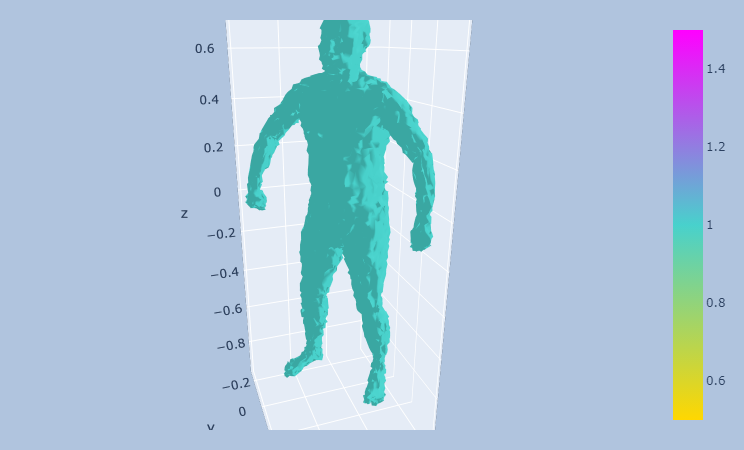

[0,1] ; c=1






  0%|                                                                                          | 0/100 [00:00<?, ?it/s]



  1%|▊                                                                                 | 1/100 [00:00<01:37,  1.02it/s]



  2%|█▋                                                                                | 2/100 [00:02<01:38,  1.00s/it]

KeyboardInterrupt: 

In [26]:
import adversarial.carlini_wagner as cw
from adversarial.carlini_wagner import CWBuilder, LowbandPerturbation

params = {
    CWBuilder.USETQDM:True,
    CWBuilder.MIN_IT:100,
    CWBuilder.LEARN_RATE:1e-4,
    CWBuilder.ADV_COEFF:1,
    CWBuilder.REG_COEFF:1,
    LowbandPerturbation.EIGS_NUMBER:40}

#choose random target
while True:
    i = random.randint(0, len(testdata)-1)
    target = random.randint(0, testdata.num_classes-1)
    y = testdata[i].y.item()
    if y != target: break
mesh = testdata[i]
print(target)

visualize(mesh.pos,mesh.face.t())
# search for adversarial example
adex = cw.generate_adversarial_example(
    mesh=mesh, classifier=MODEL, target=target,
    search_iterations=1,
    lowband_perturbation=True, 
    adversarial_loss="carlini_wagner",
    similarity_loss="local_euclidean",
    **params)

showperturbation(adex_ours)

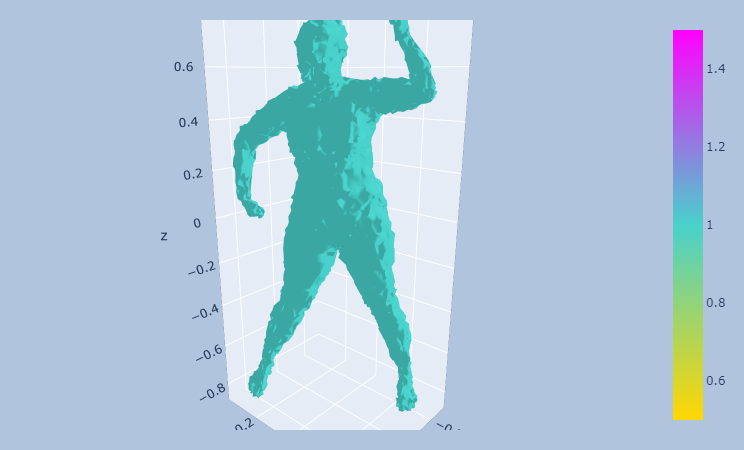

In [23]:
visualize(adex.pos,adex.faces)